In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# load unbiased MD simulation data for GO model
data_path = "/scratch/projects/hockygroup/ss12902/go_model_lda/run_unbiased"
atoms_selection = "name CA"
print("selected atoms:", atoms_selection)

# load data
prmtopFileName =  data_path + "/go.pdb"
trajFiles = [data_path+"/traj_312.dcd"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName, trajFiles, topology_format="PDB")
sel_atoms = coord.select_atoms(atoms_selection)

print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_atoms.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_atoms.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_atoms.positions - sel_atoms.center_of_geometry()
    count += 1

selected atoms: name CA
['/scratch/projects/hockygroup/ss12902/go_model_lda/run_unbiased/traj_312.dcd']
1
Number of atoms in trajectory: 56
Number of frames in trajectory: 1200006
Number of atoms being analyzed: 56
Number of frames being analyzed: 1200006


/ext3/miniconda3/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## n_clusters = 5

In [3]:
n_clusters = 5
delta = 1
n_attempts = 15
objs = []
log_likes = []
for i in range(n_attempts):
    wsgmm = torch_sgmm.ShapeGMMTorch(n_clusters, covar_type='kronecker', kabsch_thresh=1e-3, init_cluster_method='random', dtype=torch.float64, device=torch.device("cuda:0"))
    wsgmm.fit(trajData[::delta])
    print(i+1, wsgmm.log_likelihood)
    objs.append(wsgmm)
    log_likes.append(wsgmm.log_likelihood)

# select obj with max log likelihood per frame
wsgmm = objs[np.argmax(log_likes)]

1 13.027169611089132
2 13.578223201514081
3 13.958217154282929
4 12.457460543473799
5 12.465927349074352
6 14.41196650810426
7 13.428571891069359
8 14.705302242286002
9 10.941893742477829
10 10.414508627428829
11 14.497547841645947
12 14.410604691954772
13 14.286750046601853
14 14.504529117126348
15 11.586424104198588


In [3]:
with open("wsgmm_5state.pickle", "rb") as f:
    wsgmm5 = pickle.load(f)

In [5]:
# load colvar data from unbiased md data
time, q, rmsd, rg, ree = np.loadtxt("../run_unbiased/cvs.colvar", usecols=(0,1,2,3,4), unpack=True)
print(time.shape)

(1200006,)


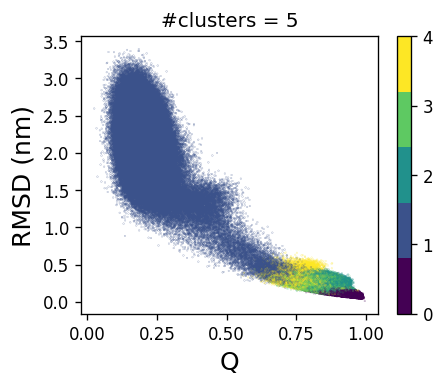

In [7]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))

# plot
plt.figure(figsize=(4,3), dpi=120)
plt.title("#clusters = 5")
plt.xlabel("Q", fontsize=15)
plt.ylabel("RMSD (nm)", fontsize=15)
plt.scatter(q, rmsd, c=wsgmm5.cluster_ids, marker=".", s=0.05, cmap=custom_cmap)
cbar = plt.colorbar(ticks=color_values)

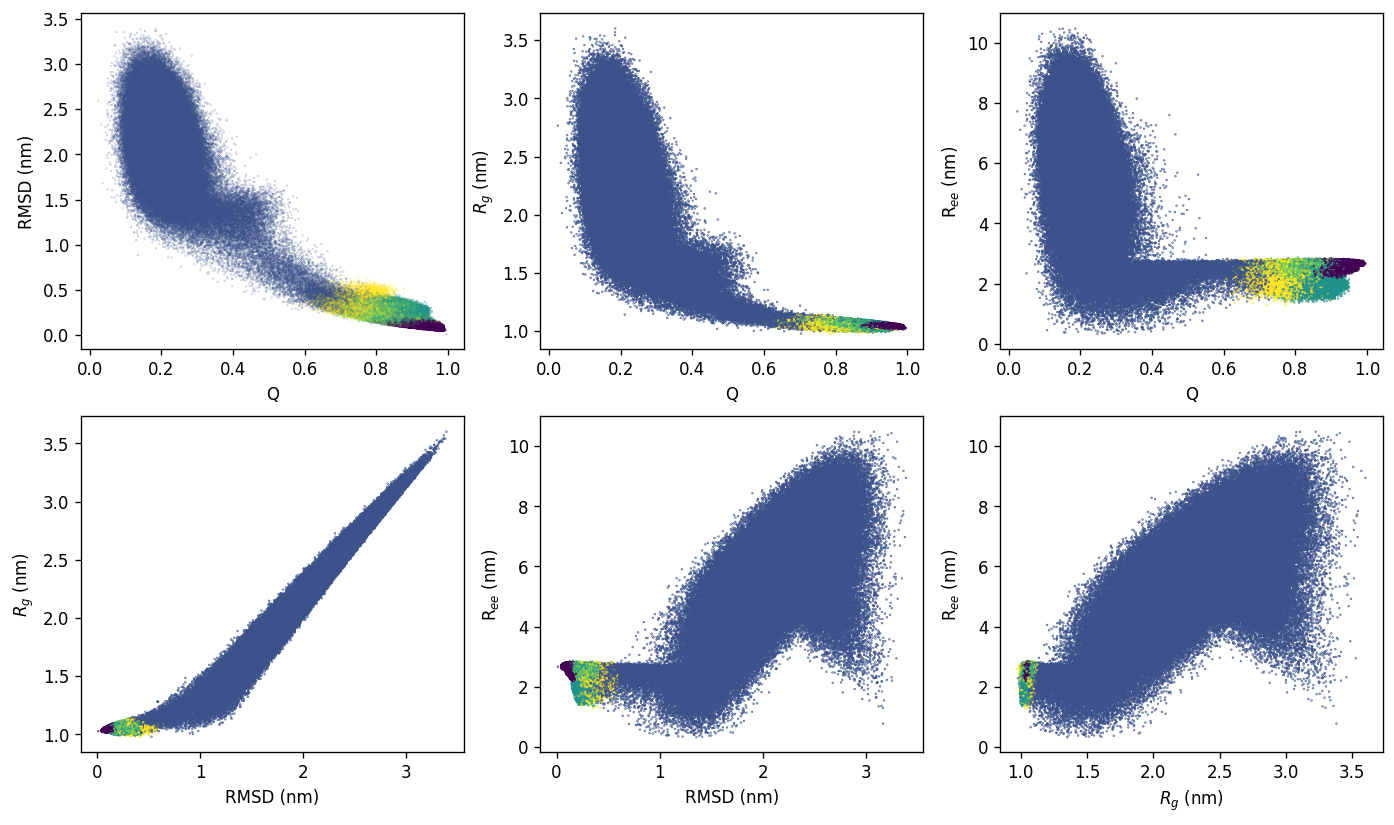

In [8]:
from matplotlib.colors import ListedColormap
color_values = np.unique(wsgmm5.cluster_ids)
cmap = plt.get_cmap('viridis', len(color_values))
custom_cmap = ListedColormap(cmap(color_values))


fig, axs = plt.subplots(2, 3, figsize=(14, 8), dpi=120)
axs = axs.reshape([-1])

#0
axs[0].set_xlabel("Q")
axs[0].set_ylabel("RMSD (nm)")
axs[0].scatter(q, rmsd, marker=".", c=wsgmm5.cluster_ids, s=0.05, cmap=custom_cmap)

#1
axs[1].set_xlabel("Q")
axs[1].set_ylabel("$R_g$ (nm)")
axs[1].scatter(q, rg, marker=".", c=wsgmm5.cluster_ids, s=0.5, cmap=custom_cmap)

#2
axs[2].set_xlabel("Q")
axs[2].set_ylabel("R$_{ee}$ (nm)")
axs[2].scatter(q, ree, marker=".", c=wsgmm5.cluster_ids, s=0.5, cmap=custom_cmap)

#3
axs[3].set_xlabel("RMSD (nm)")
axs[3].set_ylabel("$R_g$ (nm)")
axs[3].scatter(rmsd, rg, marker=".", c=wsgmm5.cluster_ids, s=0.5, cmap=custom_cmap)

#4
axs[4].set_xlabel("RMSD (nm)")
axs[4].set_ylabel("R$_{ee}$ (nm)")
axs[4].scatter(rmsd, ree, marker=".", c=wsgmm5.cluster_ids, s=0.5, cmap=custom_cmap)

#5
axs[5].set_xlabel("$R_g$ (nm)")
axs[5].set_ylabel("R$_{ee}$ (nm)")
axs[5].scatter(rg, ree, marker=".", c=wsgmm5.cluster_ids, s=0.5, cmap=custom_cmap)

In [9]:
print("lpdets: ", wsgmm5.lpdets)
print("weights: ", wsgmm5.weights)

lpdets:  [-116.34749368   43.43017953  -88.20492904  -81.07142679  -43.92685692]
weights:  [0.37620503 0.2225345  0.18351791 0.15920278 0.05853977]


In [10]:
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)
print(global_aligned_traj.shape)

(1200006, 56, 3)


## compute the committor ->

In [11]:
# setting the traj labels for each frame
traj_labels = np.zeros(coord.trajectory.n_frames)

for i in range(len(traj_labels)):
    
    # folded state
    if wsgmm5.cluster_ids[i] == 0:
        
        # assign 1 to folded state
        traj_labels[i] = 1
        
    # unfolded state
    elif wsgmm5.cluster_ids[i] == 1:
        
        # assign 0 to unfolded state
        traj_labels[i] = 0
    
    else:
        
        # assign 2 to any other frames
        traj_labels[i] = 2

print(np.unique(traj_labels))

[0. 1. 2.]


1200006


Text(0, 0.5, 'Committor')

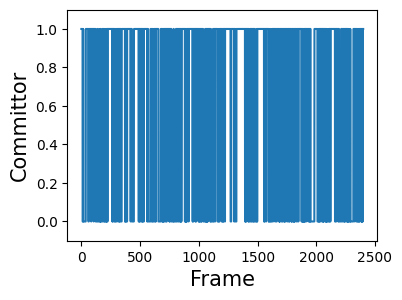

In [12]:
import compute_committor
import importlib
importlib.reload(compute_committor)
comm = compute_committor.b_before_a(traj_labels, state_a=0, state_b=1)
print(len(comm))

# make a plot for committor
plt.figure(figsize=(4,3))
plt.plot(comm[::500], marker="", ls="-")  
plt.ylim(-0.1, 1.1)
plt.xlabel("Frame", fontsize=15)
plt.ylabel("Committor", fontsize=15)

## extract frames belonging to different clusters

In [13]:
indx = []
for i in range(5):
    ci = [x[0] for x in np.argwhere(wsgmm5.cluster_ids == i)]
    indx.append(ci)
print(len(indx))

5


In [14]:
print([len(i) for i in indx])

[449797, 266987, 219223, 192416, 71583]


In [15]:
c0_frames = global_aligned_traj[indx[0]]
c1_frames = global_aligned_traj[indx[1]]

print(c0_frames.shape, c1_frames.shape)

(449797, 56, 3) (266987, 56, 3)


In [16]:
folded_unfolded_frames = np.concatenate([c0_frames, c1_frames], axis=0)
clusters_assigned = np.concatenate([np.ones(len(indx[0])), np.zeros(len(indx[1]))], axis=0)

print(folded_unfolded_frames.shape)
print(clusters_assigned.shape)

(716784, 56, 3)
(716784,)


## Linear Discriminant Analysis

In [17]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(folded_unfolded_frames.reshape(folded_unfolded_frames.shape[0], sel_atoms.n_atoms*3), clusters_assigned)
ld1 = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_atoms.n_atoms*3))[:,0]

In [18]:
print(min(ld1))
print(max(ld1))

-13.859576644730359
5.850794447643937


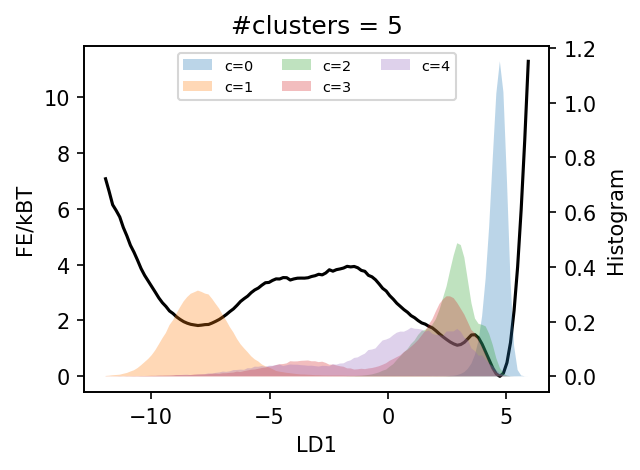

In [19]:
nbins = 120
hist, bins = np.histogram(ld1, bins=nbins, range=[-12,6], density=True)
grids = (bins[1:]+bins[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()
fig, axs = plt.subplots(1, 1, figsize=(4,3), dpi=150)
axs.set_title("#clusters = 5")
axs.set_xlabel("LD1")
axs.set_ylabel("FE/kBT")
axs.plot(grids, fe, ls="-", color="k")
axs2 = axs.twinx()
for i in range(5):
    hist, _ = np.histogram(ld1[indx[i]], bins=nbins, range=[-12,6], density=True)
    axs2.fill_between(grids, hist, label="c="+str(i), alpha=0.3)
axs2.set_ylabel("Histogram")
axs2.legend(loc="upper center", fontsize="x-small", ncol=3)

## 2D Free Energy Projections on different CV spaces (X, LD1)

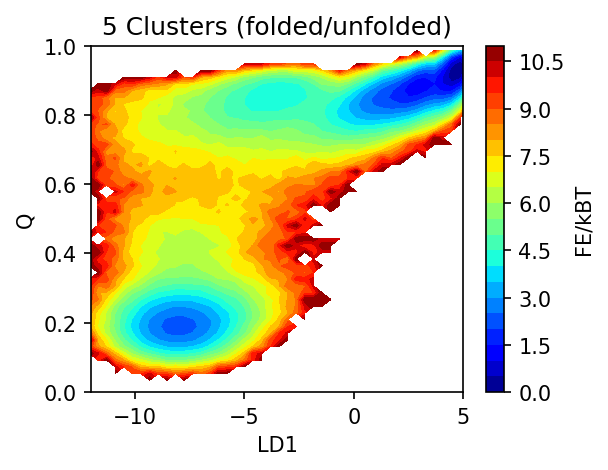

In [20]:
hist, xedges, yedges = np.histogram2d(ld1, q, bins=[50,50], density=True)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

xx, yy = np.meshgrid(xbins, ybins)
fe = -np.log(hist)
fe -= fe.min()

plt.figure(figsize=(4,3), dpi=150)
plt.title("5 Clusters (folded/unfolded)")
plt.ylim(0,1)
plt.xlim(-12, 5)
plt.xlabel("LD1")
plt.ylabel("Q")
plt.contourf(xx, yy, fe.T, cmap="jet", levels=25)
cbar = plt.colorbar()
cbar.set_label("FE/kBT")

## plot the FE colored with committor values 

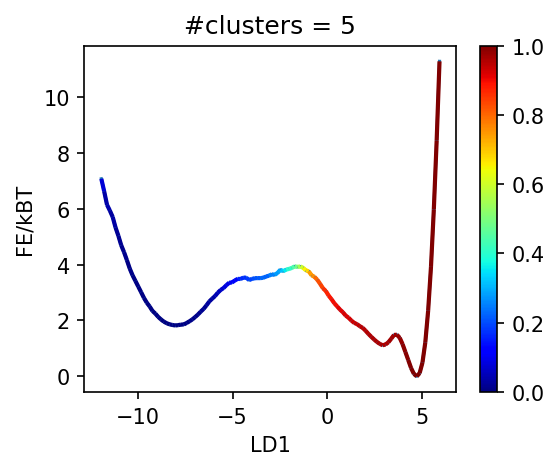

In [21]:
nbins = 120
hist, bins = np.histogram(ld1, bins=nbins, range=[-12,6], density=True)
grids = (bins[1:]+bins[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()
fig, axs = plt.subplots(1, 1, figsize=(4,3), dpi=150)
axs.set_title("#clusters = 5")
axs.set_xlabel("LD1")
axs.set_ylabel("FE/kBT")
axs.plot(grids, fe, ls="-")

dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (ld1 >=my_bin) * (ld1 <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(),comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(0.0,1.0)   # setting the limit [0,1]
lc = LineCollection(segments, cmap="jet", norm=norm)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(2.0)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

## perform multistate LD calculation ->

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda_cv = lda.fit_transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_atoms.n_atoms*3), wsgmm5.cluster_ids)[:,0]

In [23]:
print(min(lda_cv))
print(max(lda_cv))

-8.016061520210046
13.40091103793947


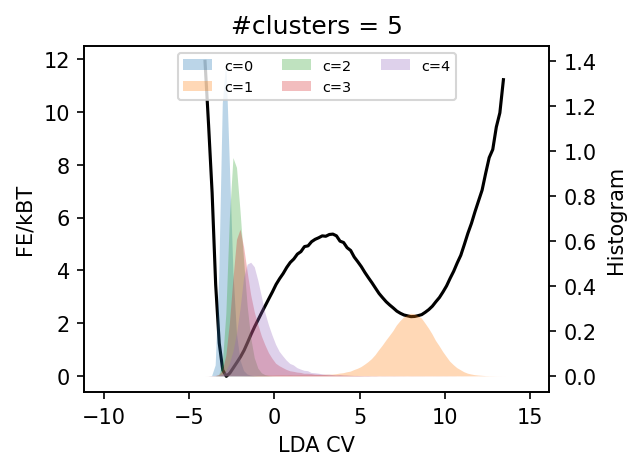

In [24]:
nbins = 120
hist, bins = np.histogram(lda_cv, bins=nbins, range=[-10,15], density=True)
grids = (bins[1:]+bins[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()
fig, axs = plt.subplots(1, 1, figsize=(4,3), dpi=150)
axs.set_title("#clusters = 5")
axs.set_xlabel("LDA CV")
axs.set_ylabel("FE/kBT")
axs.plot(grids, fe, ls="-", color="k")
axs2 = axs.twinx()
for i in range(5):
    hist, _ = np.histogram(lda_cv[indx[i]], bins=nbins, range=[-10,15], density=True)
    axs2.fill_between(grids, hist, label="c="+str(i), alpha=0.3)
axs2.set_ylabel("Histogram")
axs2.legend(loc="upper center", fontsize="x-small", ncol=3)

## make the SI figure 

In [25]:
# load
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

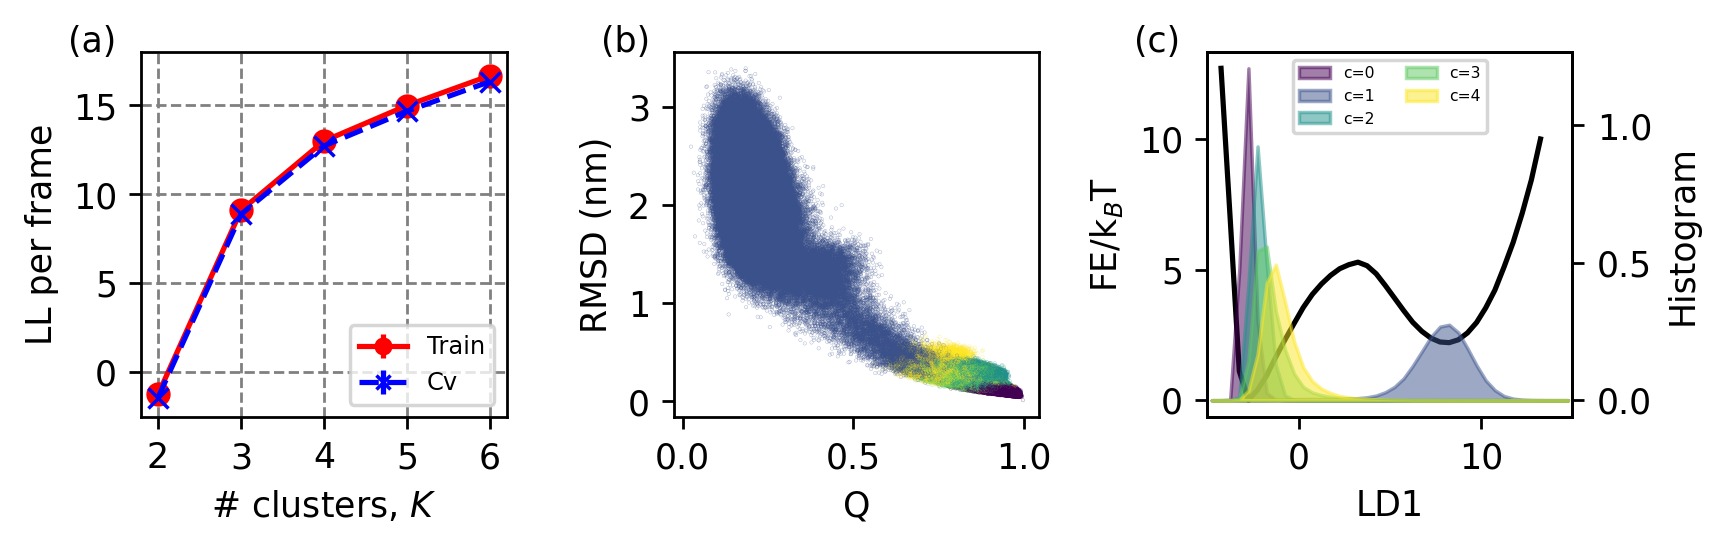

In [26]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cluster_boundaries = np.arange(6)  # You need one more boundary than the number of colors
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, 5))
norm = BoundaryNorm(cluster_boundaries, cmap.N)

fig, axs = plt.subplots(1, 3, figsize=(7,2.5), dpi=250)

#0
axs[0].set_box_aspect(1)
axs[0].text(-0.20, 1.0, "(a)", fontsize=10, transform=axs[0].transAxes)
axs[0].set_ylabel("LL per frame")
axs[0].set_xlabel("# clusters, $K$")
axs[0].grid(which='major', axis='both', color='#808080', linestyle='--')
axs[0].set_xticks(np.arange(2,7))
axs[0].errorbar(np.arange(2,7),train_mean, train_std, fmt='-o', color="r", label="Train")
axs[0].errorbar(np.arange(2,7), cv_mean, cv_std, fmt='--x', color="b", label="Cv")
axs[0].legend(fontsize="x-small", markerscale=0.7, loc="lower right")

#1
axs[1].set_box_aspect(1)
axs[1].text(-0.20, 1.0, "(b)", fontsize=10, transform=axs[1].transAxes)
axs[1].set_xlabel("Q")
axs[1].set_ylabel("RMSD (nm)")
im = axs[1].scatter(q, rmsd, c=wsgmm5.cluster_ids, marker=".", s=0.05, cmap=cmap, norm=norm, alpha=0.5)
#cbar_ax = fig.add_axes([0.41, 0.96, 0.18, 0.030])  # [x, y, width, height]
#cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5,5,1), orientation="horizontal")
#cbar.set_ticklabels(np.arange(5))
#cbar.set_label("cluster index")


#2 
nbins = 40
hist, bins = np.histogram(lda_cv, bins=nbins, range=[-5,15], density=True)
grids = (bins[1:]+bins[:-1])/2.0
fe = -np.log(hist)
fe -= fe.min()
axs[2].set_box_aspect(1)
axs[2].text(-0.20, 1.0, "(c)", fontsize=10, transform=axs[2].transAxes)
axs[2].set_xlabel("LD1")
axs[2].set_ylabel("FE/k$_{B}$T")
axs[2].set_xlim(-5,15)
axs2 = axs[2].twinx()
axs2.set_box_aspect(1)
for i in range(5):
    hist, _ = np.histogram(lda_cv[indx[i]], bins=nbins, range=[-5,15], density=True)
    axs2.fill_between(grids, hist, label="c="+str(i), alpha=0.5, color=colors[i])
axs2.set_ylabel("Histogram")
axs2.legend(loc="upper center", fontsize=4.5, ncol=2)
axs[2].plot(grids, fe, ls="-", color="k")

fig.tight_layout()

plt.savefig("SI_fig_lda_updated.png")

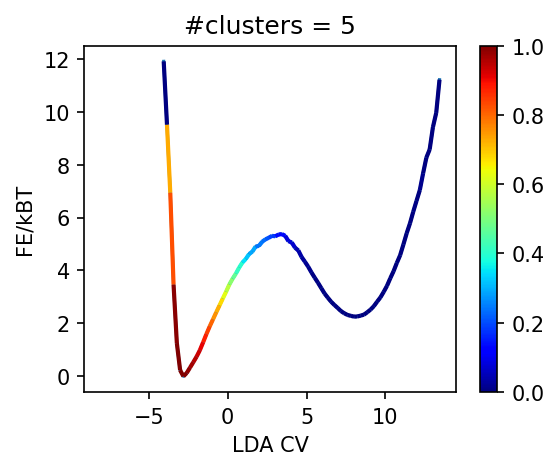

In [27]:
nbins = 120
hist, bins = np.histogram(lda_cv, bins=nbins, range=[-10,15], density=True)
grids = (bins[1:]+bins[:-1])/2.0
fe_ = -np.log(hist)
fe_ -= fe_.min()
fig, axs = plt.subplots(1, 1, figsize=(4,3), dpi=150)
axs.set_title("#clusters = 5")
axs.set_xlabel("LDA CV")
axs.set_ylabel("FE/kBT")
axs.plot(grids, fe_, ls="-")

dx = bins[1]-bins[0]
comm_average_var = []
for my_bin in bins:
    sgmm_idx = np.where( (lda_cv >=my_bin) * (lda_cv <my_bin+dx) )[0]
    comm_average_var.append([comm[sgmm_idx].mean(), comm[sgmm_idx].var()])
comm_average_var = np.array(comm_average_var)

# create the segments
points = np.array([grids, fe_]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(0.0,1.0)   # setting the limit [0,1]
lc = LineCollection(segments, cmap="jet", norm=norm)

# Set the values used for colormapping
lc.set_array(comm_average_var[:,0])
lc.set_linewidth(2.0)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

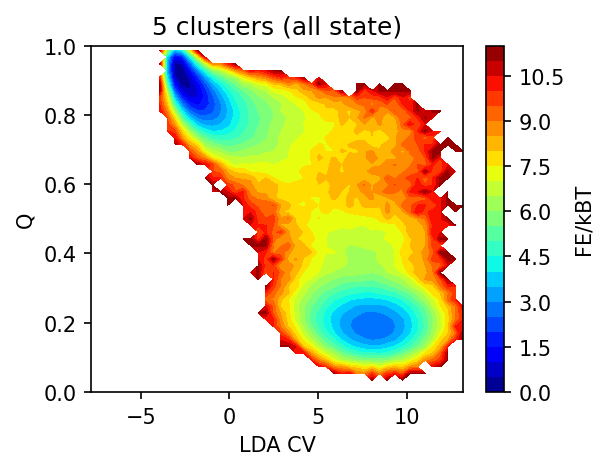

In [28]:
# make 2D FES using lda_cv and Q
hist, xedges, yedges = np.histogram2d(lda_cv, q, bins=[50,50], density=True)
xbins = (xedges[1:] + xedges[:-1])/2.0
ybins = (yedges[1:] + yedges[:-1])/2.0

xx, yy = np.meshgrid(xbins, ybins)
fe = -np.log(hist)
fe -= fe.min()

plt.figure(figsize=(4,3), dpi=150)
plt.ylim(0,1)
#plt.xlim(-12, 5)
plt.xlabel("LDA CV")
plt.ylabel("Q")
plt.title("5 clusters (all state)")
plt.contourf(xx, yy, fe.T, cmap="jet", levels=25)
cbar = plt.colorbar()
cbar.set_label("FE/kBT")